In [37]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [38]:
# 1. Baca dataset
df = pd.read_csv("./data/dataset_siswa.csv")

# Memeriksa apakah ada missing values di dataset
print("\nMissing Values per Kolom:")
print(df.isnull().sum())

# Jika ada missing values, kita bisa mengisinya dengan rata-rata kolom masing-masing
df['absensi'] = df['absensi'].fillna(df['absensi'].mean())
df['nilai'] = df['nilai'].fillna(df['nilai'].mean())

# Memeriksa kembali setelah pengisian missing values
print("\nDataset Setelah Penanganan Missing Values:")
print(df.isnull().sum())

# Menampilkan informasi dasar dari dataset
print("\nInformasi Dataset:")
print(df.info())

# Menampilkan statistik deskriptif untuk atribut numerik
print("\nStatistik Deskriptif Dataset:")
print(df.describe())


Missing Values per Kolom:
absensi    0
nilai      0
dtype: int64

Dataset Setelah Penanganan Missing Values:
absensi    0
nilai      0
dtype: int64

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   absensi  499 non-null    int64
 1   nilai    499 non-null    int64
dtypes: int64(2)
memory usage: 7.9 KB
None

Statistik Deskriptif Dataset:
          absensi       nilai
count  499.000000  499.000000
mean    48.382766   49.106212
std     29.482412   28.829487
min      0.000000    0.000000
25%     22.000000   22.500000
50%     49.000000   50.000000
75%     73.000000   74.000000
max    100.000000  100.000000


In [39]:

# 2. Kategorisasi manual performa (jika belum ada kolom 'performa')
def categorize_performance(row):
    absensi = row['absensi']
    nilai = row['nilai']
    if (absensi < 40 and nilai < 40):
        return 'Buruk'
    elif (absensi < 40 and 40 <= nilai < 70):
        return 'Buruk'
    elif (40 <= absensi < 70 and nilai < 40):
        return 'Buruk'
    elif (absensi >= 70 and nilai >= 70):
        return 'Bagus'
    elif (absensi >= 70 and 40 <= nilai < 70):
        return 'Bagus'
    elif (40 <= absensi < 70 and nilai >= 70):
        return 'Bagus'
    else:
        return 'Cukup'

if 'performa' not in df.columns:
    df['performa'] = df.apply(categorize_performance, axis=1)

print("\nContoh Data Setelah Prapemrosesan:")
print(df.head(20))


Contoh Data Setelah Prapemrosesan:
    absensi  nilai performa
0        37     40    Buruk
1         1      1    Buruk
2        42     24    Buruk
3        51     12    Buruk
4        88      3    Cukup
5         0     43    Buruk
6        30     15    Buruk
7        56     78    Bagus
8        44     99    Bagus
9        49     23    Buruk
10       98     33    Cukup
11      100     47    Bagus
12       70     76    Bagus
13        0     48    Buruk
14       36     65    Buruk
15       79     85    Bagus
16       78     79    Bagus
17       40    100    Bagus
18       13     44    Buruk
19       88     65    Bagus


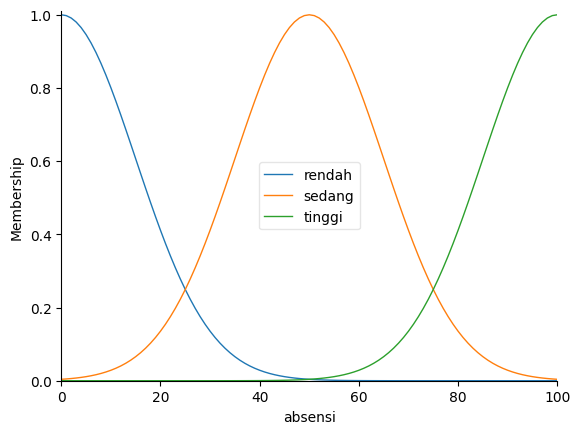

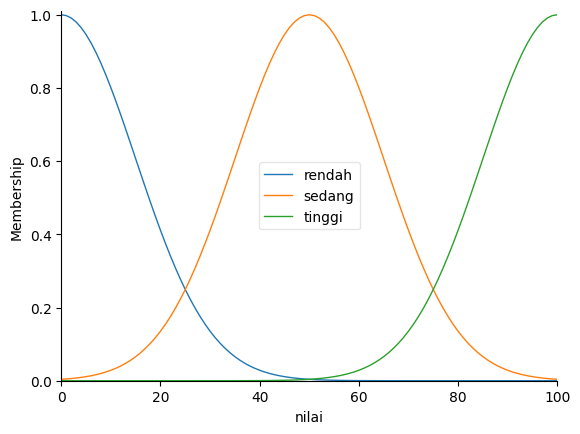

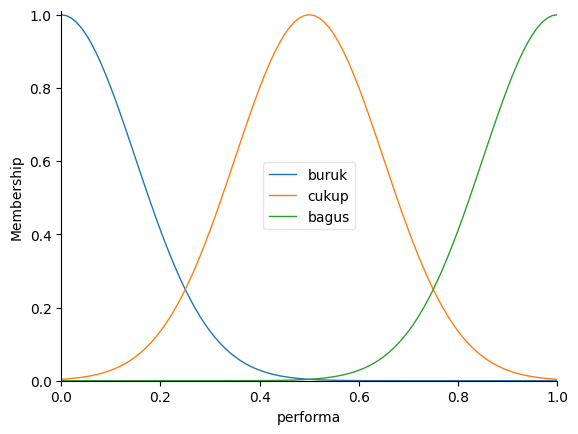

In [40]:
# 3. --------- MAMDANI (skfuzzy) ---------
absensi_fz = ctrl.Antecedent(np.arange(0, 101, 1), 'absensi')
nilai_fz = ctrl.Antecedent(np.arange(0, 101, 1), 'nilai')
performa_fz = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'performa')


absensi_fz['rendah'] = fuzz.gaussmf(absensi_fz.universe, 0, 15)
absensi_fz['sedang'] = fuzz.gaussmf(absensi_fz.universe, 50, 15)
absensi_fz['tinggi'] = fuzz.gaussmf(absensi_fz.universe, 100, 15)
absensi_fz.view()

nilai_fz['rendah'] = fuzz.gaussmf(nilai_fz.universe, 0, 15)
nilai_fz['sedang'] = fuzz.gaussmf(nilai_fz.universe, 50, 15)
nilai_fz['tinggi'] = fuzz.gaussmf(nilai_fz.universe, 100, 15)
nilai_fz.view()

performa_fz['buruk'] = fuzz.gaussmf(performa_fz.universe, 0, 0.15)
performa_fz['cukup'] = fuzz.gaussmf(performa_fz.universe, 0.5, 0.15)
performa_fz['bagus'] = fuzz.gaussmf(performa_fz.universe, 1, 0.15)
performa_fz.view()

rule1 = ctrl.Rule(absensi_fz['rendah'] & nilai_fz['rendah'], performa_fz['buruk'])
rule2 = ctrl.Rule(absensi_fz['rendah'] & nilai_fz['sedang'], performa_fz['buruk'])
rule3 = ctrl.Rule(absensi_fz['rendah'] & nilai_fz['tinggi'], performa_fz['cukup'])
rule4 = ctrl.Rule(absensi_fz['sedang'] & nilai_fz['rendah'], performa_fz['buruk'])
rule5 = ctrl.Rule(absensi_fz['sedang'] & nilai_fz['sedang'], performa_fz['cukup'])
rule6 = ctrl.Rule(absensi_fz['sedang'] & nilai_fz['tinggi'], performa_fz['bagus'])
rule7 = ctrl.Rule(absensi_fz['tinggi'] & nilai_fz['rendah'], performa_fz['cukup'])
rule8 = ctrl.Rule(absensi_fz['tinggi'] & nilai_fz['sedang'], performa_fz['bagus'])
rule9 = ctrl.Rule(absensi_fz['tinggi'] & nilai_fz['tinggi'], performa_fz['bagus'])

performa_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
performa_simulasi = ctrl.ControlSystemSimulation(performa_ctrl)

def map_fuzzy_label(score, th_buruk=0.33, th_bagus=0.66):
    if score < th_buruk:
        return "Buruk"
    elif score > th_bagus:
        return "Bagus"
    else:
        return "Cukup"

fuzzy_scores = []
fuzzy_labels = []
for idx, row in df.iterrows():
    performa_simulasi.input['absensi'] = row['absensi']
    performa_simulasi.input['nilai'] = row['nilai']
    performa_simulasi.compute()
    score = performa_simulasi.output['performa']
    fuzzy_scores.append(score)
    fuzzy_labels.append(map_fuzzy_label(score))

df['mamdani_score'] = fuzzy_scores
df['mamdani_label'] = fuzzy_labels

accuracy_mamdani = accuracy_score(df['performa'], df['mamdani_label'])
f1_mamdani = f1_score(df['performa'], df['mamdani_label'], average='weighted', labels=['Buruk', 'Cukup', 'Bagus'], zero_division=1)


In [41]:
# 4. --------- SUGENO (manual) ---------
def gaussian_membership(x, center, sigma):
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def sugeno(absensi, nilai):
    absensi_rendah = gaussian_membership(absensi, 0, 15)
    absensi_sedang = gaussian_membership(absensi, 50, 15)
    absensi_tinggi = gaussian_membership(absensi, 100, 15)

    nilai_rendah = gaussian_membership(nilai, 0, 15)
    nilai_sedang = gaussian_membership(nilai, 50, 15)
    nilai_tinggi = gaussian_membership(nilai, 100, 15)

    # Output rule berupa fungsi linear
    output = [
        0.2 * absensi + 0.2 * nilai,  # rule 1
        0.2 * absensi + 0.5 * nilai,  # rule 2
        0.2 * absensi + 0.8 * nilai,  # rule 3
        0.5 * absensi + 0.2 * nilai,  # rule 4
        0.5 * absensi + 0.5 * nilai,  # rule 5
        0.5 * absensi + 0.8 * nilai,  # rule 6
        0.8 * absensi + 0.2 * nilai,  # rule 7
        0.8 * absensi + 0.5 * nilai,  # rule 8
        0.8 * absensi + 0.8 * nilai,  # rule 9
    ]
    alpha = [
        min(absensi_rendah, nilai_rendah),   # rule 1
        min(absensi_rendah, nilai_sedang),   # rule 2
        min(absensi_rendah, nilai_tinggi),   # rule 3
        min(absensi_sedang, nilai_rendah),   # rule 4
        min(absensi_sedang, nilai_sedang),   # rule 5
        min(absensi_sedang, nilai_tinggi),   # rule 6
        min(absensi_tinggi, nilai_rendah),   # rule 7
        min(absensi_tinggi, nilai_sedang),   # rule 8
        min(absensi_tinggi, nilai_tinggi),   # rule 9
    ]
    numerator = sum(a * o for a, o in zip(alpha, output))
    denominator = sum(alpha)
    return (numerator / denominator) / 100 if denominator != 0 else 0.5

def map_sugeno_label(score, th_buruk=0.33, th_bagus=0.66):
    if score < th_buruk:
        return "Buruk"
    elif score > th_bagus:
        return "Bagus"
    else:
        return "Cukup"

sugeno_scores = []
sugeno_labels = []
for idx, row in df.iterrows():
    score = sugeno(row['absensi'], row['nilai'])
    sugeno_scores.append(score)
    sugeno_labels.append(map_sugeno_label(score))

df['sugeno_score'] = sugeno_scores
df['sugeno_label'] = sugeno_labels

accuracy_sugeno = accuracy_score(df['performa'], df['sugeno_label'])
f1_sugeno = f1_score(df['performa'], df['sugeno_label'], average='weighted', labels=['Buruk', 'Cukup', 'Bagus'], zero_division=1)

In [42]:
# 5. --------- HASIL PERBANDINGAN ---------
print("=== Evaluasi Metode Mamdani (skfuzzy) ===")
print(f"Accuracy: {accuracy_mamdani:.4f}")
print(f"F1-Score: {f1_mamdani:.4f}")

print("\n=== Evaluasi Metode Sugeno (manual) ===")
print(f"Accuracy: {accuracy_sugeno:.4f}")
print(f"F1-Score: {f1_sugeno:.4f}")

if accuracy_mamdani > accuracy_sugeno:
    print("\nMamdani lebih baik berdasarkan akurasi.")
elif accuracy_mamdani < accuracy_sugeno:
    print("\nSugeno lebih baik berdasarkan akurasi.")
else:
    print("\nKedua metode memiliki akurasi yang sama.")



=== Evaluasi Metode Mamdani (skfuzzy) ===
Accuracy: 0.7675
F1-Score: 0.7734

=== Evaluasi Metode Sugeno (manual) ===
Accuracy: 0.7375
F1-Score: 0.7391

Mamdani lebih baik berdasarkan akurasi.


In [43]:
# Ambil satu contoh data dari dataset (misal baris pertama)
sample = df.iloc[4]
absensi_sample = sample['absensi']
nilai_sample = sample['nilai']
print(f"Contoh Data:\nAbsensi: {absensi_sample}\nNilai: {nilai_sample}\nPerforma: {sample['performa']}")

Contoh Data:
Absensi: 88
Nilai: 3
Performa: Cukup


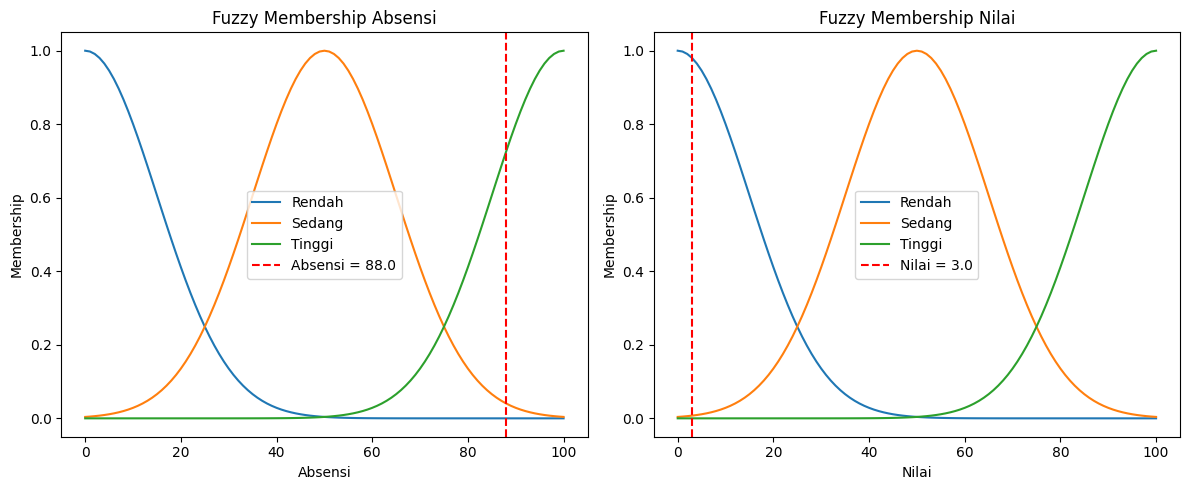

In [44]:
# Visualisasi membership function dan posisi data pada grafik
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Grafik keanggotaan Absensi
axs[0].plot(absensi_fz.universe, absensi_fz['rendah'].mf, label='Rendah')
axs[0].plot(absensi_fz.universe, absensi_fz['sedang'].mf, label='Sedang')
axs[0].plot(absensi_fz.universe, absensi_fz['tinggi'].mf, label='Tinggi')
axs[0].axvline(absensi_sample, color='red', linestyle='--', label=f'Absensi = {absensi_sample:.1f}')
axs[0].set_title('Fuzzy Membership Absensi')
axs[0].set_xlabel('Absensi')
axs[0].set_ylabel('Membership')
axs[0].legend()

# Grafik keanggotaan Nilai
axs[1].plot(nilai_fz.universe, nilai_fz['rendah'].mf, label='Rendah')
axs[1].plot(nilai_fz.universe, nilai_fz['sedang'].mf, label='Sedang')
axs[1].plot(nilai_fz.universe, nilai_fz['tinggi'].mf, label='Tinggi')
axs[1].axvline(nilai_sample, color='red', linestyle='--', label=f'Nilai = {nilai_sample:.1f}')
axs[1].set_title('Fuzzy Membership Nilai')
axs[1].set_xlabel('Nilai')
axs[1].set_ylabel('Membership')
axs[1].legend()

plt.tight_layout()
plt.show()

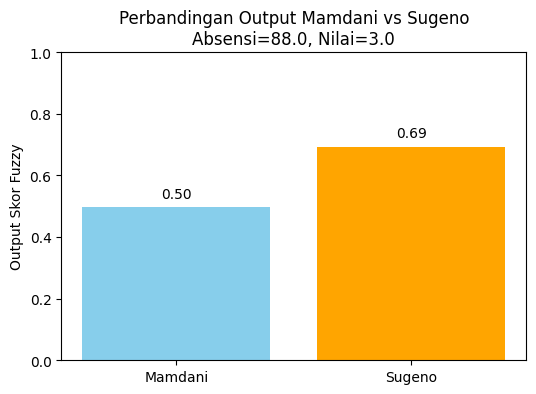

In [45]:
absensi_sample = sample['absensi']
nilai_sample = sample['nilai']

# Hitung skor Mamdani dan Sugeno untuk data ini
mamdani_score = sample['mamdani_score']
sugeno_score = sample['sugeno_score']

# Visualisasi perbandingan skor output Mamdani vs Sugeno
plt.figure(figsize=(6, 4))
plt.bar(['Mamdani', 'Sugeno'], [mamdani_score, sugeno_score], color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Output Skor Fuzzy')
plt.title(f'Perbandingan Output Mamdani vs Sugeno\nAbsensi={absensi_sample:.1f}, Nilai={nilai_sample:.1f}')
plt.text(0, mamdani_score + 0.03, f"{mamdani_score:.2f}", ha='center')
plt.text(1, sugeno_score + 0.03, f"{sugeno_score:.2f}", ha='center')
plt.show()